## Summarize the centriole compensation

Required input:

For the midline: a list of X_coordinate and a list of Y_coordinate

For the edge: a list of X_coordinate and a list of Y_coordinate

For the centriole: a list of list containing [X_coordinate, Y_coordinate, an angle (in degrees)]

In [2]:
import import_ipynb

import time

from tools.Centriole_Characteristic import *
from tools.Extract_Experiment_Characteristic import *
from tools.CNN_Tools import *
from tools.Graphical_Tools import *
from tools.Centriole_Detection import *

#from tools.Worm_Segmentation import extract_worm_edge

importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Centriole_Characteristic.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\ToolBox.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Midline_Edge_Reformater.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Extract_Experiment_Characteristic.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\CNN_Tools.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Graphical_Tools.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Analysis_Tools.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Centriole_Detection.ipynb


In [9]:

# Are  Midline and Edge already define in an excel file?
# Cyril's Note: For Schmidtea it's probably a better to perform a manual definition of the edge of the worm:
#         The segmentation is performed with the DIC 10x. As consequences:
#                 -> The edge of the worm where there is no centriole is included in the mask. In the Dev Cell, 2019, this zone was not taken into consideration
#                 -> It's always better (if possible) to use the 100x objective to draw the edge: there is chromatic aberration (not compensated so far) between 10x and 100x leading to mis calculation of the distance.
Load_Mid_and_Edge = True

# Are you just testing the angle compensation?
Test_Angle_Compensation = False

path_img_100x = './exemple/140820_WT-3 (V3-2c)-171221_small.tif'
path_img_100x  = './full_worm/MAX_180417_Dvl1&2_Odf2-injection_root_17dpa_63x_Full_1_Stitched.tif'
path_img_10x   = './full_worm/C1-180417_Dvl1&2_Odf2-injection_root_17dpa_10x_Full_1.tif'

problem = 'classification'


In [ ]:
t_ini = time.time()
################################################################
#####             MIDLINE AND WORM EDGE           ##############
################################################################
# Load Midline and Edge coordinates from a 'classical' excel file
if Load_Mid_and_Edge:
    path = './full_worm/180417_Dvl1&2_Odf2-injection_root_17dpa_63x_Full_1.xlsm'

    db = get_xls_values(path)

    x_mid = db['worm_midline']['x']
    y_mid = db['worm_midline']['y']
    x_edg = db['worm_edge']['x']
    y_edg = db['worm_edge']['y']

    newY_mid, newY_edg = [], []
    for y in y_mid:
        newY_mid.append(-y)

    for y in y_edg:
        newY_edg.append(-y)
        
    print('Midline and Edge loaded')
    
    worm = [x_mid, newY_mid, x_edg, newY_edg ]

    
# Automatic characterization of the midline and the edge
## So far (17 November 2020) do not work at all. 
## Ideas: size of the image, contrast (rm background per example)
else:
    midline, edge = extract_worm_edge(path_img_10x, quantile = 0.01)
    worm = [midline[0], midline[1], edge[0], edge[1]]
    
    print('Midline and Edge computed')
    pass

########################################################################################

#+++++++++++++++++++++++++++++
# TO DO
# Adjust the midline with the edge of the worm'''
#
#+++++++++++++++++++++++++++++

# Reformat a midline and Edge in a given number of segment and subsegment
midline_final = aggregate_segment_char(x_mid, newY_mid, 
                                       x_edg, newY_edg, 
                                       n_midline_seg = 50, 
                                       n_sub_segment = 25, 
                                       n_edge_seg = 200)

print('Edge and Midline reformated')




#######################################################################################
#####             CENTRIOLE IDENTIFICATION AND ANGLE PREDICITON          ##############
#######################################################################################

# This step is usefull here to get a list of centriole already treated
if Test_Angle_Compensation:
    import xlrd  

    xls_name = "./data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm"

    with xlrd.open_workbook(xls_name) as xls_file:
        # Go to appropriate sheet (index 0)
        xls_sheet = xls_file.sheet_by_index(0)

    a_list_of_centriole = []

    pixel_size = db['image_pixel_size_in_um']
    x_shift = db['image_shift']['x']
    y_shift = db['image_shift']['y']

    for row in range(xls_sheet.nrows - 7):
        if isinstance(xls_sheet.cell_value(row + 7, 3), (float, int)):
            X = xls_sheet.cell_value(row + 7, 3)/pixel_size + x_shift
            Y = -(xls_sheet.cell_value(row + 7, 4)/pixel_size + y_shift)
            angle = xls_sheet.cell_value(row + 7, 1)

            a_list_of_centriole.append(((X, Y), angle))
        
        
# Extraction of the centriole and analysis from an raw image
# 17 November 2020: problem can only be 'classification' (with 72 classes)
else:
    # Identification of the Centrioles
    img = cv2.imread(path_img_100x, cv2.IMREAD_UNCHANGED)
    print('Image Loaded')

    dog_img = dog_and_otsu(img)
    find_maxima_img = find_maxima(img)
    
    combine_img = dog_img*find_maxima_img
    
    #####   Not Required   ####
    img_to_save = Image.fromarray(dog_img)
    img_to_save.save('dog.tif' )
    img_to_save = Image.fromarray(find_maxima_img)
    img_to_save.save('find_maxima.tif' )
    img_to_save = Image.fromarray(combine_img)
    img_to_save.save('combine.tif' )
    ###########################
    
    
    # CUDA is faster but not always available
    if torch.cuda.is_available():                                  
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Loading of the model
    if problem == 'classification':
        model = VGG_Schmidtea(n_classes = 72).to(device)
        model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_classification.pth', map_location = device))
    else:
        model = VGG_Schmidtea(n_classes = 1).to(device)
        model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_regression.pth', map_location = device))
    
    model.eval()
    #+++++++++++++++++++++++++++++++++++++
    # I don't know how the centriole image will come but to do the prediction:
    
    # Extraction of coordinates where centrioles are
    ypts, xpts = np.where(combine_img == 1)
    
    a_list_of_centriole = []
    
    x_shape, y_shape = img.shape[1], img.shape[0] 
    xlim, ylim  = x_shape - 16 , y_shape - 16
    for i in range(len(ypts)):
        x, y = xpts[i], ypts[i]
        
        if y > 16 and x > 16 and y < ylim and x < xlim:
            #centriole_extracted = img.crop((xpts[i], ypts[i], xpts[i] + 32, ypts[i] + 32))
            centriole = img[y-16:y+16, x-16:x+16]
            centriole = np.asarray(centriole, dtype = "uint8")
            centriole = centriole.reshape(1 , 1, 32, 32)
            # Inside predictor:
            centriole = torch.from_numpy(centriole)
            centriole = centriole.float().to(device)
            
            with torch.no_grad():
                output = model(centriole)
            
            angle = output.max(1)[1]
            angle = angle.numpy()
            
            #print(centriole_extracted)
            #angle = predictor(model, centriole_extracted, device, problem = 'classification')
            a_list_of_centriole.append(((xpts[i], ypts[i]), angle[0]))


print('Centrioles angle predicted and compensated')


####################################################################################

reoriented_centriole = []
for a_centriole in a_list_of_centriole:
    tmp_list = list(centriole_characterizator(a_centriole, midline_final))
    tmp_list.insert(1,a_centriole[0][0])
    tmp_list.insert(2,a_centriole[0][1])

    reoriented_centriole.append(tmp_list)
    
print('Centriole Dataset reformated')


t_final = time.time()

print(f"Time: {t_final-t_ini}" )

File loaded: ./full_worm/180417_Dvl1&2_Odf2-injection_root_17dpa_63x_Full_1.xlsm
Midline and Edge loaded
Edge and Midline reformated
Image Loaded
Image transformed in uint8
Differential of Gaussian performed


In [7]:
import math
arrowLen = 5
a_new_centriole_list = []

for i in a_list_of_centriole:
    angle = i[1] +90
    x = i[0][0]
    y = i[0][1]
    new_coord = [x-arrowLen*math.cos(math.radians(angle)), y-arrowLen*math.sin(math.radians(angle)), x+arrowLen*math.cos(math.radians(angle)), y+arrowLen*math.sin(math.radians(angle)), angle]
    a_new_centriole_list.append(new_coord)
    
a_new_centriole_list = np.array(a_new_centriole_list)

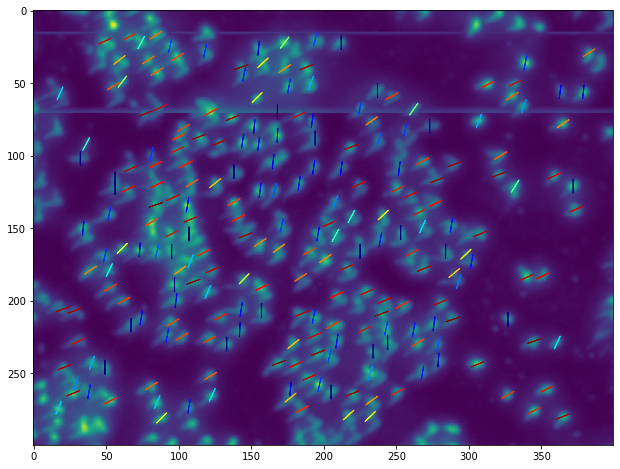

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

DATA = np.random.rand(6,5)

"""
DATA = np.zeros((1,5))
toto = [0, 0, 1, 1, 2]

DATA[0] = toto
"""

DATA = a_new_centriole_list

#print(DATA[:,4])

cmap = plt.cm.jet

cNorm  = colors.Normalize(vmin=np.min(DATA[:,4]), vmax=np.max(DATA[:,4]))

scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

plt.figure(figsize=(15,8))

plt.imshow(img)

for idx in range(0,len(DATA[:,1])):
    colorVal = scalarMap.to_rgba(DATA[idx,4])
    plt.arrow(DATA[idx,0],  #x1
              DATA[idx,1],  # y1
              DATA[idx,2]-DATA[idx,0], # x2 - x1
              DATA[idx,3]-DATA[idx,1], # y2 - y1
              color=colorVal)

plt.show()  

In [102]:
toto = a_new_centriole_list[0]

print(toto[0])
print(toto[1])
print(toto[2]-toto[0])
print(toto[3]-toto[1])

83.45536096498498
16.161329432054576
1.0892780700300477
1.677341135890849


 Idx | Angle |Lateral| Longi   || Marker | Color
------------------------------------------------
   1 |  -34  |  0.64 |  0.48   ||   o    | darkorange
 200 |  -22  |  0.40 |  0.49   ||   o    | darkviolet
 800 |   31  |  0.68 |  0.43   ||   o    | dodgerblue
 300 |  -17  |  0.16 |  0.46   ||   o    | crimson
 400 |    8  |  0.12 |  0.47   ||   o    | magenta
 500 |   29  |  0.39 |  0.44   ||   v    | darkorange
 600 |   12  |  0.56 |  0.43   ||   v    | darkviolet
 700 |   34  |  0.69 |  0.42   ||   v    | dodgerblue


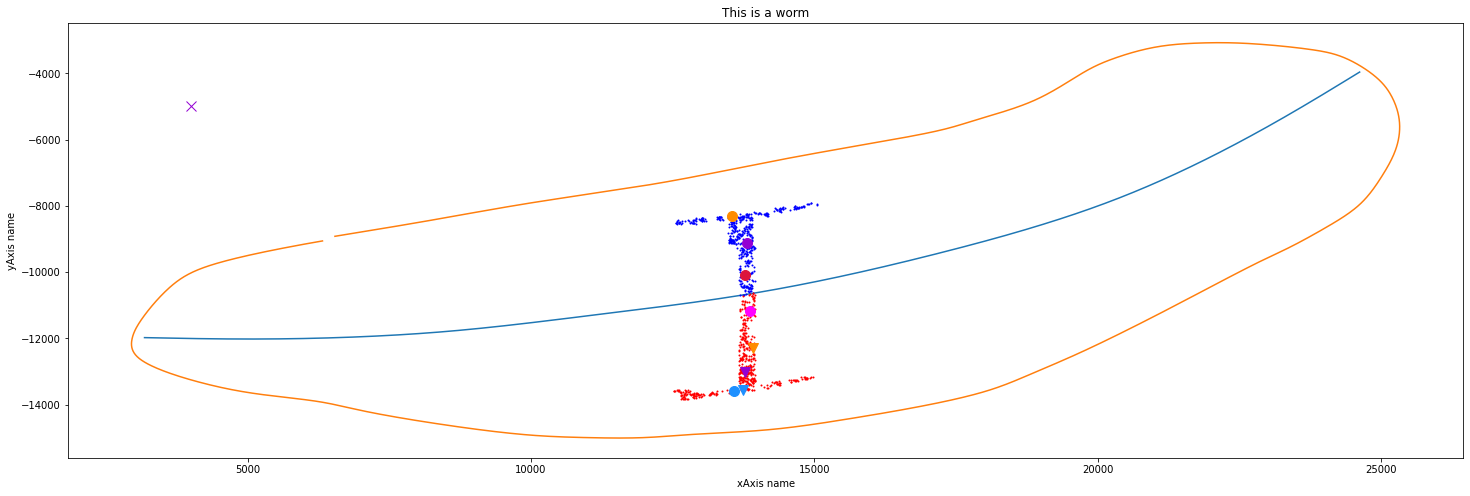

In [12]:
# Graphical Representation of the worms and the analyzed centrioles
# If you want to see some specific centrioles, add them in the list
list_of_desired_centriole = [1, 200, 800, 300, 400, 500, 600, 700]

# If you want to see the location of a specific coordinate (Write None if you don't want to see them )
X_coordinate = 4000
Y_coordinate = -5000

Worm_And_Centriole(reoriented_centriole, worm, list_of_desired_centriole, (X_coordinate, Y_coordinate))

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


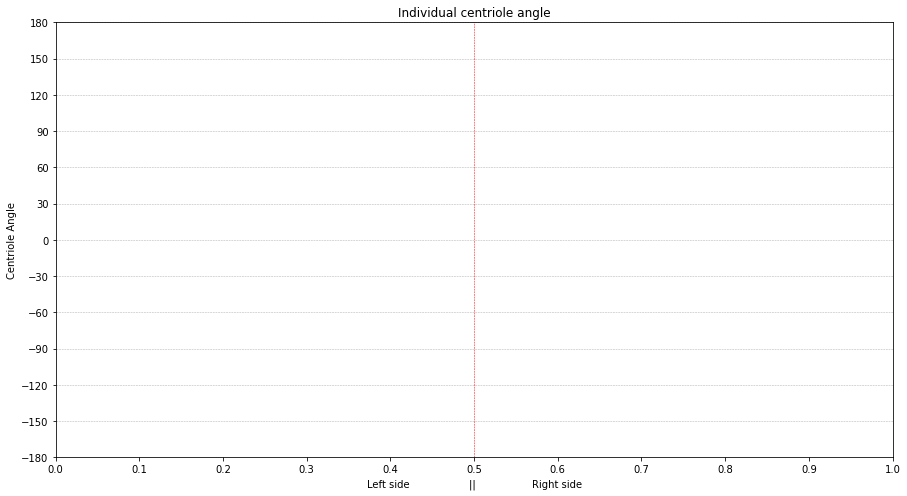

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


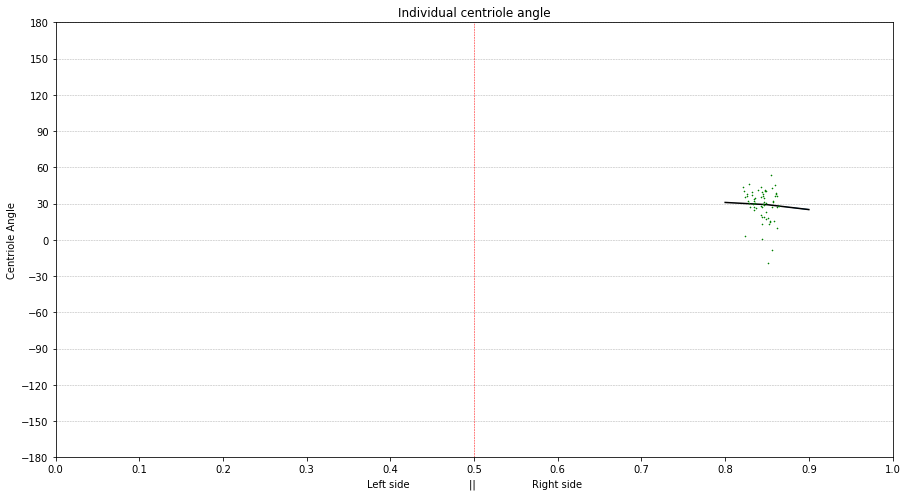

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


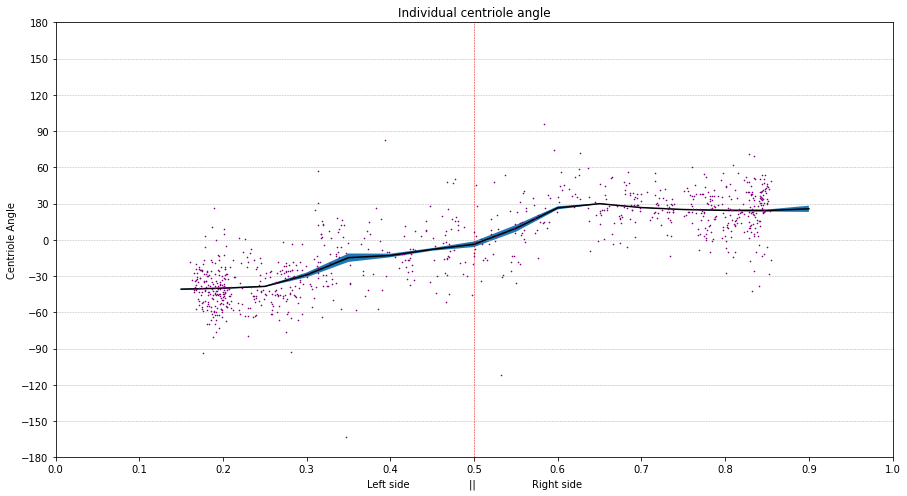

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


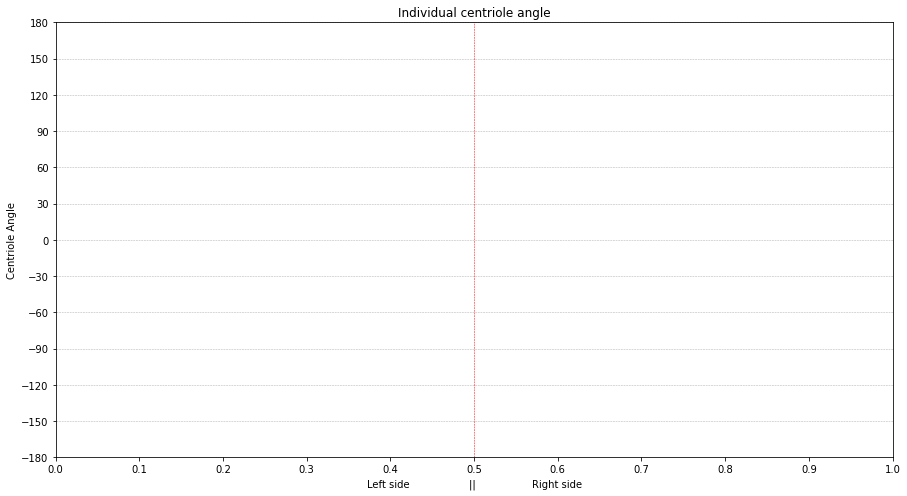

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment


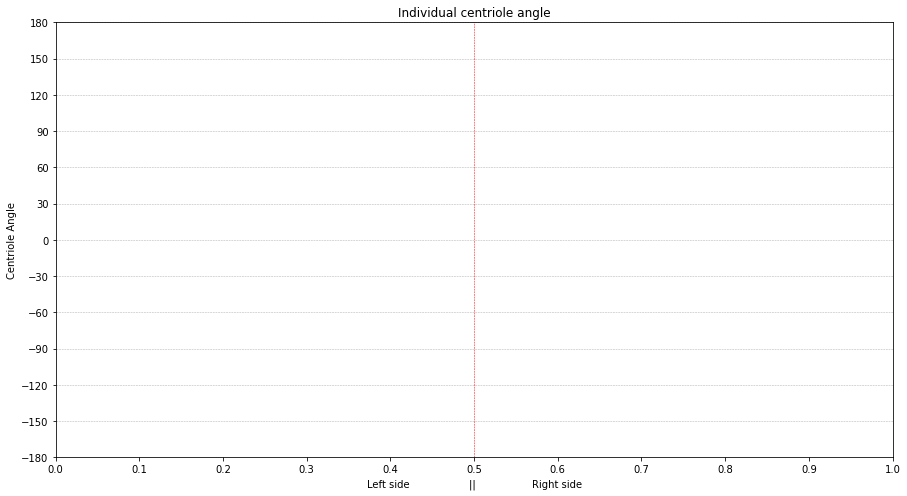

In [13]:
# Graphical representation of the results 

for i in range(5):
    print_a_antero_posterior_result(reoriented_centriole, i, n_ante_post_segment = 5, a_lat_size = 0.1, a_lat_step = 0.05)

In [7]:
import numpy as np


test = np.zeros((5,5))

coord = ((0,0), (1,1), (0,1), (3,3), (4,4)) 

for i in coord:
    test[i] = 1

In [8]:
print(test)

[[1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [9]:
ypts, xpts = np.where(test == 1)

In [10]:
print(ypts, xpts)

[0 0 1 3 4] [0 1 1 3 4]


In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import csv

import import_ipynb

from tools.ToolBox import json_loader
from tools.ToolBox import csv_saver

from tools.CNN_Tools import VGG_Schmidtea
from tools.CNN_Tools import train
from tools.CNN_Tools import validate

from tools.Dataset_Tools import centriole_dataset
from tools.Dataset_Tools import dataset_creator
from tools.Dataset_Tools import dataset_loader
from tools.Dataset_Tools import dataset_aggregator

In [2]:
problem = 'regression'
problem = 'classification'


if problem == 'classification':
    n_class = 72
    
else:
    n_class = 1

In [3]:
load_dataset = True

# Creation/Loading of the Dataset
if load_dataset == False:   
    train_loader, validation_loader = dataset_creator(path_json = './data_json/',
                                                     batch_size = 700,
                                                     n_class = n_class,
                                                     save_dataset = True)  
elif problem == 'classification':
    train_loader, validation_loader = dataset_loader(path = './data/',
                                                     #train_set = 'train_loader_dataset_b700_unNormalized.pth',
                                                     train_set = 'train_data_pregression_b700_unNormalized-003.pth',
                                                     #val_set = 'validation_loader_dataset_b700_unNormalized.pth')
                                                     val_set = 'validation_data_pregression_b700_unNormalized.pth')
    
else: 
    train_loader, validation_loader = dataset_loader(path = './data/',
                                                 #train_set = 'train_data_pregression_b700_unNormalized.pth',
                                                 train_set = 'data_train_regression_normalized.pth',
                                                 val_set = 'validation_data_pregression_b700_unNormalized.pth')

In [4]:
load_weight = False


if torch.cuda.is_available():                                  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)


# Criterion and CNN loading
if problem == 'classification':
    criterion = nn.CrossEntropyLoss()
    model = VGG_Schmidtea(n_classes = n_class).to(device)
else: 
    criterion = nn.MSELoss()
    model = VGG_Schmidtea(n_classes = 1).to(device)


# Weight loading
if load_weight == True:
    model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_classification.pth'))

Using PyTorch version: 1.6.0+cpu  Device: cpu


torch.Size([700, 1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 1, 32, 32])
torch.Size([2, 1, 32, 32])
tensor([67]) tensor(70)


<ipython-input-34-24549fcd3648>:37: RuntimeWarning: invalid value encountered in true_divide
  confusion_matrix = confusion_matrix / col_sum


<AxesSubplot:>

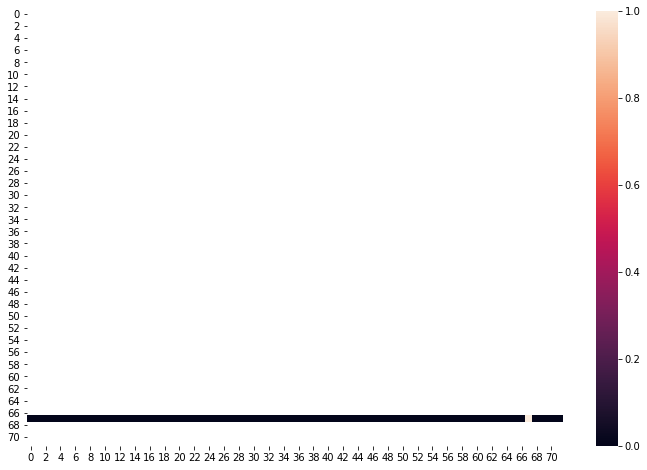

In [34]:
confusion_matrix = torch.zeros(n_class, n_class)

#model.load_state_dict(torch.load('./weight/VGG_schmidtea_weigth_epoch_regression1500.pth'))
model.load_state_dict(torch.load('./weight/VGG_schmidtea_weight_classification.pth', map_location = device))
model.eval()
toto = 0
for batch_idx, batch in enumerate(validation_loader):
    if toto == 0:
        # Copy data to GPU if needed
        img = batch['image'].float().to(device)
        angle = batch['angle'].long().to(device)
        angle = angle // 5
        print(img[:].size())
        print(img[0].size())
        print(img[:1].size())
        print(img[:2].size())

        with torch.no_grad(): 
   
            output = model(img[:1])

        # get the index of the max log-probability
        pred_angle = output.max(1)[1]
        print(pred_angle, angle[1])

        for a, p in zip(angle.view(-1), pred_angle.view(-1)):
            confusion_matrix[a.long(), p.long()] +=1
            
        toto +=1
    else:
        pass
            
# Data in %
col_sum = confusion_matrix.numpy().sum(axis=1)
col_sum = np.reshape(col_sum, [n_class, -1])

confusion_matrix = confusion_matrix / col_sum
    
df_cm = pd.DataFrame(confusion_matrix.numpy())

plt.figure(figsize = (12,8))
sn.heatmap(df_cm)

In [16]:
import seaborn as sn

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++